# Analysis of Layers By Activation

In another notebook I analysed the behaviour of GPT2 layers by activations in different layers of transformer.

In this one I do a bulk test on the tokens that are selection vs. real world tokens.

**Written by:** [Yash Bonde](https://www.linkedin.com/in/yash-bonde/)

**Date:** 13th March, 2021

# Some of the generation and tests may be offensive. Proceed with Caution.

In [1]:
!nvidia-smi

Mon Mar 22 20:22:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   20C    P8     5W / 350W |      2MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import pandas as pd
import numpy as np
import random
import torch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, AutoModel
import re
from torch import nn
from tqdm import trange
import json
from datasets import load_dataset

import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple

In [3]:
def set_seed(seed):
  if seed is not None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
total_data_for_rupesh = []

In [5]:
model =  AutoModelForCausalLM.from_pretrained("gpt2-xl")
tok = AutoTokenizer.from_pretrained("gpt2-xl")
tok.pad_token = "PAD"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)
model.eval()
print("Total parameters:", sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values()))

device  cuda:0
Total parameters: 1557611200


In [6]:
# define generic model output
OutputDict = namedtuple("OutputDict", ["logits", "hidden_states"])

# pick any random text from wikipedia, GPTs are not trained on it
# we first take any random text from the internet and create probability distribution (PD) of
# what was predicted vs. what the token that is from the text
text = """Artificial general intelligence (AGI) is the hypothetical ability of an intelligent
agent to understand or learn any intellectual task that a human being can. It is a primary goal
of some artificial intelligence research and a common topic in science fiction and futures studies.
AGI can also be referred to as strong AI, full AI, or general intelligent action.
Some academic sources reserve the term "strong AI" for computer programs that can experience
sentience, self-awareness and consciousness. Today's AI is speculated to be decades away from AGI."""

In [7]:
def get_data(text, category):
  tokens = tok.encode(text + tok.eos_token, return_tensors = "pt")
  with torch.no_grad():
    out = model(
      tokens.to(device),
      output_hidden_states = True,
      # output_attentions = True,
      return_dict = True
    )
    attn_mapped = OutputDict(
      logits = out.logits.cpu()[0].softmax(dim = -1),
      hidden_states = [model.lm_head(
        model.transformer.ln_f(x)
      ).cpu().softmax(dim = -1)[0]
      for x in out.hidden_states[:-1]] # since last is same as logits
    )
  
  tokens = tokens[0] # unsqueeze
  tokens_words = [tok.decode(x.item()) for x in tokens] # get words
  
  # now get the layer wise token scores
  tok_ar = torch.arange(len(tokens) - 1)
  layer_wise_max_scores = []         # max scores per layers
  layer_wise_max_score_tokens = []   # max scores per layers
  layer_wise_actual_token_score = [] # score for the actual tokens

  for log in attn_mapped.hidden_states:
    # for each step what was the highest probability
    layer_wise_actual_token_score.append(log[tok_ar, tokens[1:]].numpy())

    # for max scores
    this_layer_tokens = log.max(-1)
    layer_wise_max_score_tokens.append([tok.decode(x.item()) for x in this_layer_tokens.indices][1:])
    layer_wise_max_scores.append(this_layer_tokens.values.numpy()[1:])

  
  # joined scores
  stacked_scores = np.stack(layer_wise_actual_token_score)
  layer_wise_max_scores = np.stack(layer_wise_max_scores)
  layer_wise_max_score_tokens = np.array(layer_wise_max_score_tokens)
  
  data = {
    "probabilities": stacked_scores.T,
    "scores": np.log(stacked_scores).T,
    "layer_wise_max_score_tokens": layer_wise_max_score_tokens.T,
    "layer_wise_max_scores": layer_wise_max_scores.T,
    "text": text,
    "tokens": tokens_words,
    "category": category,
    "type": "human"
  }
  
  return data

In [12]:
data_to_tokenize = {}
this_samples = []
this_topic = None
with open("./samples0.txt", "r") as f:
  for l in f:
    if len(l) == 0:
      continue
    
    if l.startswith("#"):
      if this_topic is not None:
        data_to_tokenize[this_topic] = this_samples[:-1]
      
      # new topic
      this_samples = []
      this_topic = l[1:].strip()
    
    else:
      this_samples.append(l.strip())
    

In [19]:
k = random.choice(list(data_to_tokenize.keys()))
text = random.choice(data_to_tokenize[k])
k, text

('Indian History',
 'According to the International Monetary Fund (IMF), the Indian economy in 2019 was nominally worth $2.9 trillion; it is the fifth-largest economy by market exchange rates, and is around $11 trillion, the third-largest by purchasing power parity (PPP).')

In [73]:
data = get_data(text, k)
data.update({
  k:data[k].tolist()
  for k in ['probabilities', 'scores', 'layer_wise_max_score_tokens', 'layer_wise_max_scores']
})

<ipython-input-7-7457431fad9f>:44: RuntimeWarning: divide by zero encountered in log
  "scores": np.log(stacked_scores).T,


In [ ]:
# generate data
# see reports at ks2labs.github.ioks/gpt2-reports/heatmap.html
data_points = []
for _, k in zip(trange(len(data_to_tokenize)), data_to_tokenize):
  for text in data_to_tokenize[k]:
    data = get_data(text, k)
    data.update({
      k:data[k].tolist()
      for k in ['probabilities', 'scores', 'layer_wise_max_score_tokens', 'layer_wise_max_scores']
    })
    data_points.append(data)

In [148]:
with open("./data_samples.json", "w") as f:
  f.write(json.dumps(data_points))

In [81]:
tokens = tok.encode(text + tok.eos_token, return_tensors = "pt")
with torch.no_grad():
  out = model(
    tokens.to(device),
    output_hidden_states = True,
    # output_attentions = True,
    return_dict = True
  )
  attn_mapped = OutputDict(
    logits = out.logits.cpu()[0].softmax(dim = -1),
    hidden_states = [model.lm_head(
      model.transformer.ln_f(x)
    ).cpu().softmax(dim = -1)[0]
    for x in out.hidden_states] # since last is same as logits
  )
  
tokens = tokens[0] # unsqueeze
tokens_words = [tok.decode(x.item()) for x in tokens]

In [82]:
attn_mapped.logits.shape, attn_mapped.hidden_states[-1].shape

(torch.Size([57, 50257]), torch.Size([57, 50257]))

In [83]:
attn_mapped.logits[:3, :4]

tensor([[2.4557e-06, 9.9452e-06, 1.0835e-08, 4.2600e-08],
        [3.1049e-06, 8.9851e-06, 1.5347e-07, 1.4562e-07],
        [2.3317e-06, 6.9870e-06, 1.8139e-07, 4.9616e-07]])

In [84]:
logf = attn_mapped.hidden_states[-1]
logf[:3, :4]

tensor([[1.5960e-09, 1.1245e-08, 2.0681e-13, 1.1483e-12],
        [3.4877e-12, 2.4550e-11, 2.5085e-15, 1.4957e-15],
        [1.1582e-10, 8.0590e-10, 2.0876e-13, 1.7515e-12]])

In [85]:
tok_ar = torch.arange(len(tokens) - 1)

# max scores per layers
layer_wise_max_scores = []
layer_wise_max_score_tokens = []

# score for the actual tokens
layer_wise_actual_token_score = []

for log in attn_mapped.hidden_states:
  # for each step what was the highest probability
  layer_wise_actual_token_score.append(log[tok_ar, tokens[1:]].numpy())
  
  # for max scores
  this_layer_tokens = log.max(-1)
  layer_wise_max_score_tokens.append([tok.decode(x.item()) for x in this_layer_tokens.indices])
  layer_wise_max_scores.append(this_layer_tokens.values.numpy())

Text(0.5, 1.0, "Words Probabilities [gpt2-xl] (First Word: 'According')")

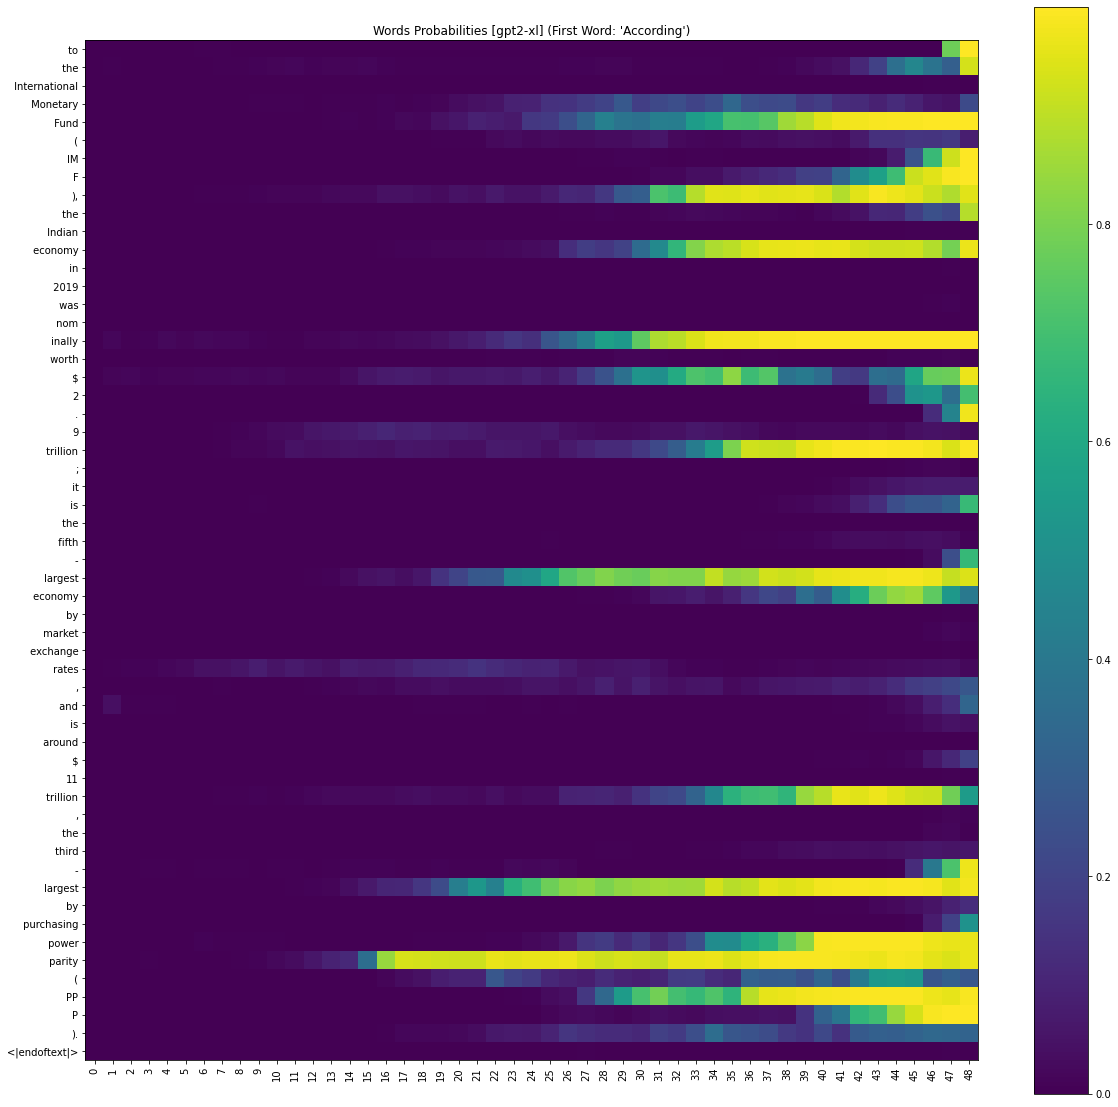

In [86]:
stacked_scores = np.stack(layer_wise_actual_token_score)

plt.figure(figsize = (20, 20))
plt.imshow(stacked_scores.T)
plt.colorbar()
plt.yticks(ticks = tok_ar, labels = tokens_words[1:])
plt.xticks(
  ticks = np.arange(len(stacked_scores)),
  labels = [str(i) for i in range(len(stacked_scores))],
  rotation = 90
)
plt.title(f"Words Probabilities [gpt2-xl] (First Word: '{tokens_words[0]}')")

In [90]:
stacked_scores.T[-1]

array([1.1155062e-22, 9.8627538e-04, 6.0808309e-04, 5.2345928e-04,
       4.9708621e-04, 4.6454294e-04, 2.9152480e-04, 3.2470064e-04,
       3.4648209e-04, 4.1379916e-04, 3.7759487e-04, 3.8787641e-04,
       6.0462451e-04, 6.1038649e-04, 8.7928411e-04, 1.3871891e-03,
       1.3014864e-03, 1.2662732e-03, 1.1603192e-03, 1.1172771e-03,
       1.0172169e-03, 1.3853246e-03, 1.1109826e-03, 1.6310056e-03,
       1.2988384e-03, 1.2740345e-03, 2.3812132e-03, 4.3055802e-03,
       2.6893308e-03, 1.2686691e-03, 4.4356822e-04, 3.2788637e-04,
       3.6243646e-04, 6.1619264e-04, 4.2587932e-04, 4.2657607e-04,
       3.6870799e-04, 4.2666611e-04, 2.4589355e-04, 1.6905063e-04,
       3.0375266e-04, 3.2047249e-04, 4.0505841e-04, 5.5316638e-04,
       7.9528504e-04, 1.4053232e-03, 3.8060891e-03, 5.5805664e-03,
       1.0864473e-03], dtype=float32)

Text(0.5, 1.0, 'gpt2-XL')

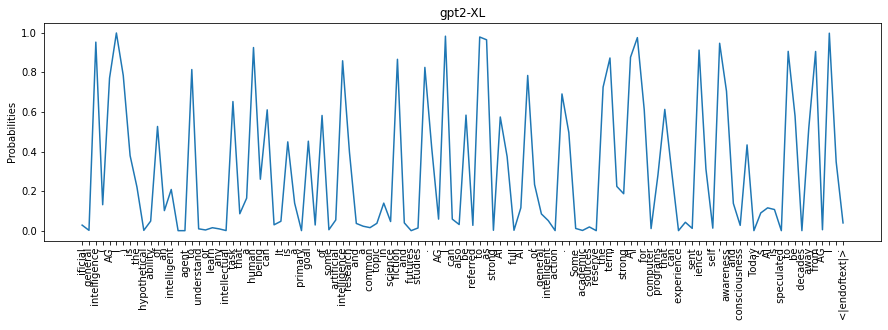

In [12]:
plt.figure(figsize = (15, 4))
plt.plot(layer_wise_actual_token_score[-1])
plt.xticks(ticks = tok_ar, labels = tokens_words[1:], rotation = 90)
plt.ylabel("Probabilities")
plt.title("gpt2-XL")

In [74]:
set_seed(123)
output = model.generate(
  input_ids = tokens[:1].unsqueeze(0).to(device),
  max_length=len(tokens_words),
  num_beams=1,
  do_sample=False, # <- randomness
  output_scores = True,
  return_dict_in_generate = True,
  output_hidden_states=True,
)
gen_tok_words = [tok.decode(x) for x in output.sequences[0]]
print(tok.decode(output.sequences[0]))
scores = torch.cat(output.scores)
scores = scores.softmax(-1).max(-1).values.cpu().numpy()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Artifact Creature - Construct

When Krosan Tusker enters the battlefield, create a 1/1 green Saproling creature token.

Whenever Krosan Tusker attacks, you may pay. If you do, create a 1/1 green Saproling creature token.

2/2<|endoftext|>


In [75]:
output.sequences[0]

tensor([ 8001, 29660, 33248,   532, 28407,   198,   198,  2215,   509,  4951,
          272, 46233,  6122, 14170,   262, 13480,    11,  2251,   257,   352,
           14,    16,  4077, 35980,   305,  1359,  7185, 11241,    13,   198,
          198, 28877,   509,  4951,   272, 46233,  6122,  3434,    11,   345,
          743,  1414,   764,  1002,   345,   466,    11,  2251,   257,   352,
           14,    16,  4077, 35980,   305,  1359,  7185, 11241,    13,   198,
          198,    17,    14,    17, 50256], device='cuda:0')

Text(0, 0.5, 'Probabilities')

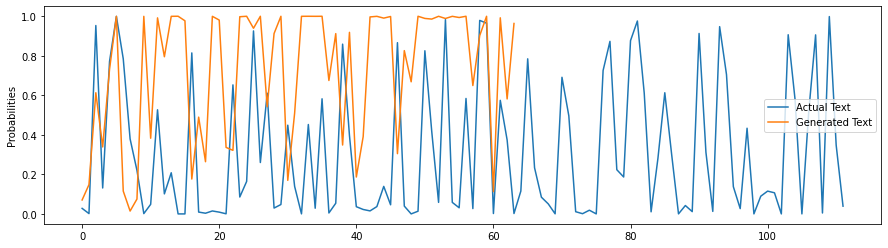

In [76]:
plt.figure(figsize = (15, 4))
plt.plot(layer_wise_actual_token_score[-1], label = "Actual Text")
plt.plot(scores, label = "Generated Text")
plt.legend()
plt.ylabel("Probabilities")

In [77]:
with torch.no_grad():
  # first we pass the hidden states through lm_head
  # output.hidden_states = [n_tokens, n_layers, n_embd
  logits = torch.cat([
    torch.cat([
      model.lm_head(model.transformer.ln_f(y[0])).softmax(dim = -1)
      for y in x
    ], dim = 0).unsqueeze(0) for x in output.hidden_states
  ], dim = 0)
  print(logits.size())
  layer_wise_token_scores = logits[torch.arange(logits.size(0)), :, output.sequences[0][1:]].detach().cpu().numpy()

torch.Size([64, 49, 50257])


Text(0.5, 1.0, "Words Probabilities [gpt2-xl] [Generated] (First Word: 'Art')")

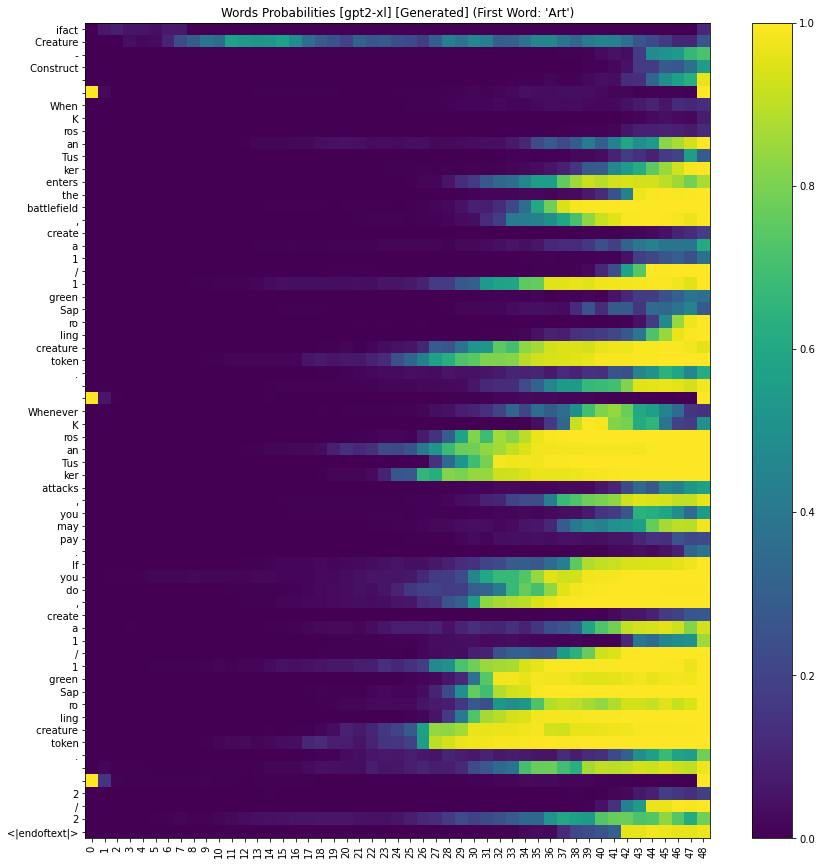

In [78]:
tok_ar = np.arange(len(layer_wise_token_scores))
plt.figure(figsize = (15, 15))
plt.imshow(layer_wise_token_scores)
plt.colorbar()
plt.yticks(ticks = tok_ar, labels = gen_tok_words[1:])
plt.xticks(
  ticks = np.arange(len(layer_wise_token_scores.T)),
  labels = [str(i) for i in range(len(layer_wise_token_scores.T))],
  rotation = 90
)
plt.title(f"Words Probabilities [gpt2-xl] [Generated] (First Word: '{tokens_words[0]}')")

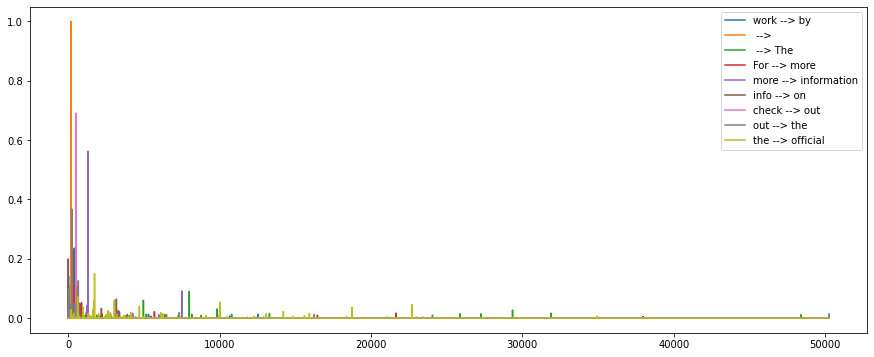

In [47]:
scores = torch.cat(output.scores).softmax(-1).cpu()[:10].numpy()

plt.figure(figsize = (15, 6))
for i,s in enumerate(scores[1:]):
  token = tok.decode(output.sequences[0][i+1])
  actual = tok.decode([s.argmax()])
  plt.plot(s, label = f"{token.strip()} --> {actual.strip()}")
plt.legend()

Using `do_sample=True` means we are introducing randomnes in the generated sequence and how can we give it some prior for what it needs to do.